In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

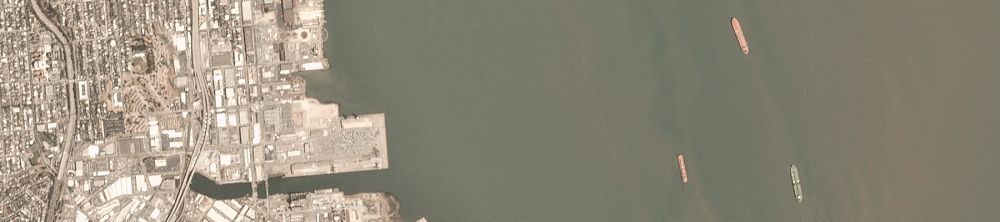

**DATASET**

Satellite imagery provides unique insights into various markets, including agriculture, defense and intelligence, energy, and finance. New commercial imagery providers, such as Planet, are using constellations of small satellites to capture images of the entire Earth every day. This flood of new imagery is outgrowing the ability for organizations to manually look at each image that gets captured, and there is a need for machine learning and computer vision algorithms to help automate the analysis process. The aim of this dataset is to help address the difficult task of detecting the location of large ships in satellite images. Automating this process can be applied to many issues including monitoring port activity levels and supply chain analysis.

The dataset consists of image chips extracted from Planet satellite imagery collected over the San Francisco Bay and San Pedro Bay areas of California. It includes 4000 80x80 RGB images labeled with either a "ship" or "no-ship" classification. Image chips were derived from PlanetScope full-frame visual scene products, which are orthorectified to a 3 meter pixel size.

Provided is a zipped directory shipsnet.zip that contains the entire dataset as .png image chips. Each individual image filename follows a specific format: {label} __ {scene id} __ {longitude} _ {latitude}.png

label: Valued 1 or 0, representing the "ship" class and "no-ship" class, respectively.
scene id: The unique identifier of the PlanetScope visual scene the image chip was extracted from. The scene id can be used with the Planet API to discover and download the entire scene.
longitude_latitude: The longitude and latitude coordinates of the image center point, with values separated by a single underscore.
The dataset is also distributed as a JSON formatted text file shipsnet.json. The loaded object contains data, label, scene_ids, and location lists.

The pixel value data for each 80x80 RGB image is stored as a list of 19200 integers within the data list. The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue. The image is stored in row-major order, so that the first 80 entries of the array are the red channel values of the first row of the image.

The list values at index i in labels, scene_ids, and locations each correspond to the i-th image in the data list.

**CLASS LABELS**

The "ship" class includes 1000 images. Images in this class are near-centered on the body of a single ship. Ships of different sizes, orientations, and atmospheric collection conditions are included. Example images from this class are shown below.

https://i.imgur.com/tLsSoTz.png

The "no-ship" class includes 3000 images. A third of these are a random sampling of different landcover features - water, vegetion, bare earth, buildings, etc. - that do not include any portion of an ship. The next third are "partial ships" that contain only a portion of an ship, but not enough to meet the full definition of the "ship" class. The last third are images that have previously been mislabeled by machine learning models, typically caused by bright pixels or strong linear features. Example images from this class are shown below.

https://imgur.com/Q3daQMC.png


**Acknowledgements**

Satellite imagery used to build this dataset is made available through Planet's Open California dataset, which is openly licensed. As such, this dataset is also available under the same CC-BY-SA license. Users can sign up for a free Planet account to search, view, and download thier imagery and gain access to their API.

**Importing Modules**

In [21]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import tensorflow as tf
from tensorflow.keras import models, layers

# # disable all debugging logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

**Importing Data**

In [22]:
df = pd.read_json('../input/ships-in-satellite-imagery/shipsnet.json')
df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


Number of No Ships 3000
Number of Ships 1000


<AxesSubplot:xlabel='labels', ylabel='count'>

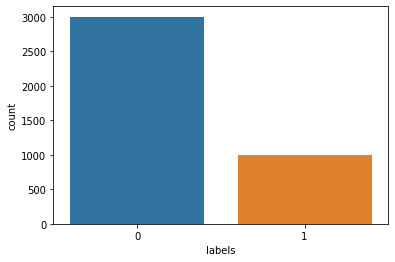

In [24]:
print('Number of No Ships', df["labels"].value_counts()[0])
print('Number of Ships', df["labels"].value_counts()[1])
sns.countplot(x=df['labels'])

In [25]:
df = df.drop(['locations', 'scene_ids'], axis=1)
df.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [26]:
# df.describe()
print(df.isna().any())
print(len(df['data'].iloc[0]))

data      False
labels    False
dtype: bool
19200


In [27]:
# Normalize Data
df['X'] = df['data'].apply(lambda x : np.array(x) / 255)
print(df['X'].shape)

# Resize Data
df['X'] = df['X'].apply(lambda x : x.reshape([3, 80, 80]))
print(df['X'][0].shape)

# Transpose Chip
df['X'] = df['X'].apply(lambda x : x.reshape([3, 80, 80]).transpose([1,2,0]))
print(df['X'][0].shape)

(4000,)
(3, 80, 80)
(80, 80, 3)


Visualize Data

In [28]:
df.head(2)   

,data,labels,X
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[[[0.3215686274509804, 0.3686274509803922, 0.3..."
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[[[0.2980392156862745, 0.33725490196078434, 0...."


In [29]:
df = df.drop('data', axis=1)
df.head()

,labels,X
0,1,"[[[0.3215686274509804, 0.3686274509803922, 0.3..."
1,1,"[[[0.2980392156862745, 0.33725490196078434, 0...."
2,1,"[[[0.49019607843137253, 0.5333333333333333, 0...."
3,1,"[[[0.4, 0.4117647058823529, 0.3411764705882353..."
4,1,"[[[0.3058823529411765, 0.3215686274509804, 0.2..."


In [30]:
# Class Labels
class_labels = ['Not a Ship', 'Ship']

In [31]:
rows = df.sample(20)
rows.head()
data = []
for index, row in rows.iterrows():
    data.append(row)
data[:2]

[labels                                                    0
 X         [[[0.5137254901960784, 0.44313725490196076, 0....
 Name: 3694, dtype: object,
 labels                                                    0
 X         [[[0.6078431372549019, 0.5490196078431373, 0.4...
 Name: 1003, dtype: object]

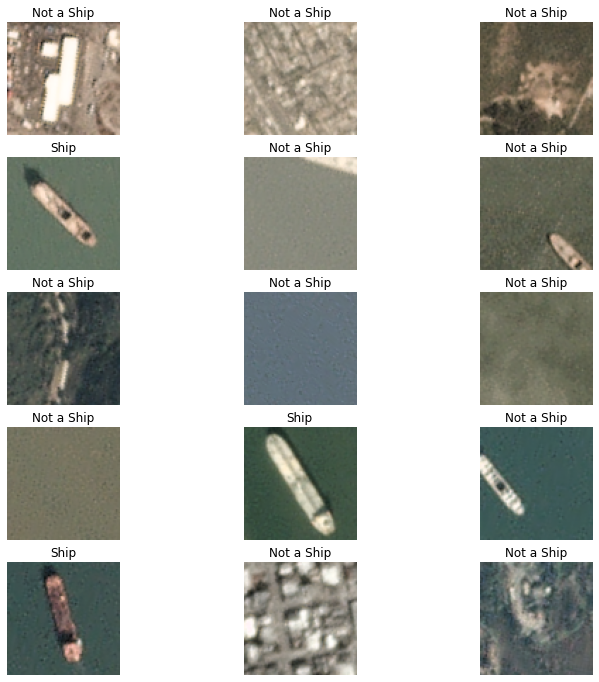

In [32]:
plt.figure(figsize=(12,12))
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.imshow(data[i][1])
    label = class_labels[data[i][0]]
    plt.title(label)
    plt.axis('off')
plt.show()

**Splitting Data**

In [33]:
print(df.head())
print()
X = df['X']
y = df['labels']
# Convert to float to enable it to be tensor ready

X = np.array(X.tolist()).astype(float)
y = np.array(y.tolist()).astype(float)
print(X.shape, y.shape)

   labels                                                  X
0       1  [[[0.3215686274509804, 0.3686274509803922, 0.3...
1       1  [[[0.2980392156862745, 0.33725490196078434, 0....
2       1  [[[0.49019607843137253, 0.5333333333333333, 0....
3       1  [[[0.4, 0.4117647058823529, 0.3411764705882353...
4       1  [[[0.3058823529411765, 0.3215686274509804, 0.2...

(4000, 80, 80, 3) (4000,)


In [34]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.1, random_state=5, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3240, 80, 80, 3) (3240,)
(360, 80, 80, 3) (360,)
(400, 80, 80, 3) (400,)


**Build Custom CNN Module**

In [35]:
input_shape = (80,80,3)
# CNN Layers

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation="relu", padding='same', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

# ANN Layers
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 80, 80, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 38, 38, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 64)         

In [39]:
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
            )

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

In [41]:
history = model.fit(
    X_train, 
    y_train, 
    epochs = 30,  
    validation_data = (X_val, y_val),
    batch_size = 64,
    callbacks=[callback]
)

Epoch 1/30
51/51 [==============================] - 0s 10ms/step - loss: 0.0419 - accuracy: 0.9836 - val_loss: 0.0619 - val_accuracy: 0.9833
Epoch 2/30
51/51 [==============================] - 0s 8ms/step - loss: 0.0333 - accuracy: 0.9886 - val_loss: 0.0760 - val_accuracy: 0.9806
Epoch 3/30
51/51 [==============================] - 0s 8ms/step - loss: 0.0340 - accuracy: 0.9892 - val_loss: 0.0729 - val_accuracy: 0.9750
Epoch 4/30
51/51 [==============================] - 0s 9ms/step - loss: 0.0370 - accuracy: 0.9861 - val_loss: 0.0665 - val_accuracy: 0.9778
Epoch 5/30
51/51 [==============================] - 0s 8ms/step - loss: 0.0229 - accuracy: 0.9926 - val_loss: 0.0822 - val_accuracy: 0.9750
Epoch 6/30
51/51 [==============================] - 1s 10ms/step - loss: 0.0332 - accuracy: 0.9889 - val_loss: 0.0739 - val_accuracy: 0.9778
Epoch 7/30
51/51 [==============================] - 1s 12ms/step - loss: 0.0268 - accuracy: 0.9889 - val_loss: 0.0961 - val_accuracy: 0.9694
Epoch 8/30
51/51 

**Evaluating Model**

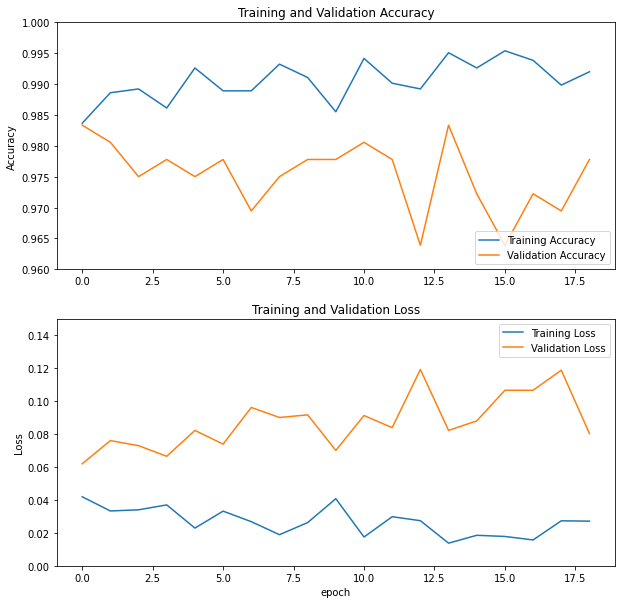

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.96,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,0.15])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [59]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 5ms/step - loss: 0.0752 - accuracy: 0.9850


[0.07521887123584747, 0.9850000143051147]

In [60]:
y_pred = model.predict(X_test)
y_pred[:2]

array([[3.4608753e-08],
       [1.8150852e-11]], dtype=float32)

In [63]:
yp = []
for element in y_pred:
    if element > 0.49:
        yp.append(1)
    else:  
        yp.append(0)

yp[:5]

[0, 0, 0, 0, 0]

In [65]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, yp, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       300
           1       0.98      0.96      0.97       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



Text(69.0, 0.5, 'True')

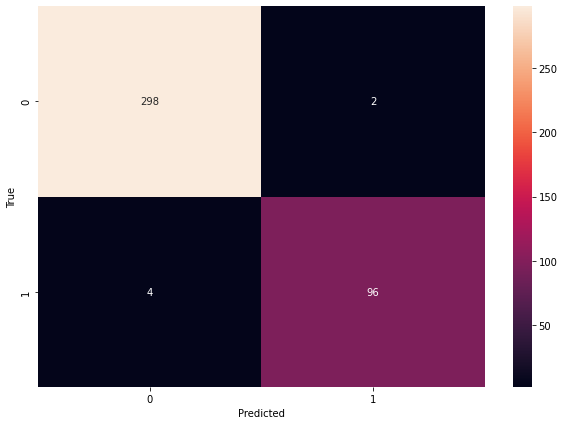

In [68]:
cm = confusion_matrix(y_test, yp)
plt.figure(figsize= (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')